- 색을 자동으로 칠해주는 인공지능
 - Let There be color 모델
- LAB 색 체계
 - L: 명도
 - A,B: 채널과 색을 나타내는데 A,B 채널로 이루어진다
- Let Ther be Color 모델
 - raw level 특징 추출기: 이미지의 raw level 특징 추출
 - global level 특징 추출기: 이미지의 전체적인 특징
 - middle level 특징 추출기: 중간크기의 특징 추출
 - 컬러라이제이션 신경망: 특징으로부터 색을 학습

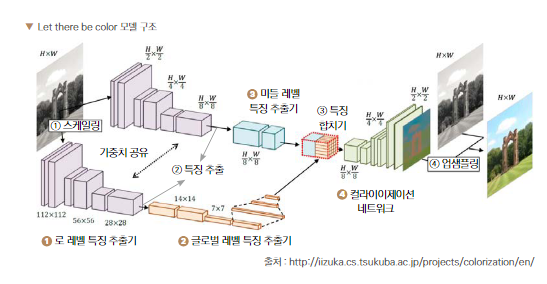

In [1]:
import glob
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
!unzip /content/drive/MyDrive/machinelearning/자동채색.zip

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: Images/2844846111_8c1cbfc75d.jpg  
  inflating: Images/2844963839_ff09cdb81f.jpg  
  inflating: Images/2845246160_d0d1bbd6f0.jpg  
  inflating: Images/2845691057_d4ab89d889.jpg  
  inflating: Images/2845845721_d0bc113ff7.jpg  
  inflating: Images/2846037553_1a1de50709.jpg  
  inflating: Images/2846785268_904c5fcf9f.jpg  
  inflating: Images/2846843520_b0e6211478.jpg  
  inflating: Images/2847514745_9a35493023.jpg  
  inflating: Images/2847615962_c330bded6e.jpg  
  inflating: Images/2847859796_4d9cb0d31f.jpg  
  inflating: Images/2848266893_9693c66275.jpg  
  inflating: Images/2848571082_26454cb981.jpg  
  inflating: Images/2848895544_6d06210e9d.jpg  
  inflating: Images/2848977044_446a31d86e.jpg  
  inflating: Images/2849194983_2968c72832.jpg  
  inflating: Images/2850719435_221f15e951.jpg  
  inflating: Images/2851198725_37b6027625.jpg  
  inflating: Images/2851304910_b5721199bc.jpg  
  inflating: Images/2851931813_eaf8ed7be3.jpg  
  in

In [3]:
imgs = glob.glob("/content/Images/*.jpg")

In [4]:
imgs[:10]

['/content/Images/1999444757_1b92efb590.jpg',
 '/content/Images/2822290399_97c809d43b.jpg',
 '/content/Images/440190907_bf8b7ba8ef.jpg',
 '/content/Images/3342855466_44038a8aa3.jpg',
 '/content/Images/2795352290_9209b214f3.jpg',
 '/content/Images/640203018_c0e7175831.jpg',
 '/content/Images/3182121297_38c99b2769.jpg',
 '/content/Images/3624676866_8f6d0efcc9.jpg',
 '/content/Images/2261550615_b6c25d987b.jpg',
 '/content/Images/2657643451_b9ddb0b58f.jpg']

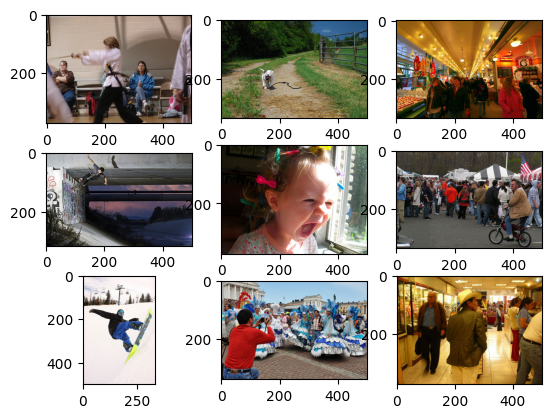

In [6]:
for i in range(9):
  img = Image.open(imgs[i])
  plt.subplot(3,3,i+1)
  plt.imshow(img)

In [8]:
import cv2
import numpy as np
from torch.utils.data.dataset import Dataset

In [10]:
def rgbTolab(rgb):
  return cv2.cvtColor(rgb, cv2.COLOR_RGB2LAB)

def labTorgb(lab):
  return cv2.cvtColor(lab, cv2.COLOR_LAB2LRGB)

In [11]:
class AutoColoring(Dataset):
  def __init__(self):
    self.data = glob.glob("/content/Images/*.jpg")
  def __len__(self):
    return len(self.data)
  def __getitem__(self, index):
    rgb = np.array(Image.open(self.data[index]).resize((256,256)))
    lab = rgbTolab(rgb)
    lab = lab.transpose((2,0,1)).astype(np.float32)
    return lab[0], lab[1:]

In [12]:
import torch
import torch.nn as nn

In [40]:
class LowLabel(nn.Module):
  def __init__(self) -> None:
    super(LowLabel,self).__init__()
    self.conv1 = nn.Conv2d(1,64,kernel_size=3,stride=2,padding=1)
    self.bat1 = nn.BatchNorm2d(64)
    self.conv2 = nn.Conv2d(64,128,kernel_size=3,stride=1,padding=1)
    self.bat2 = nn.BatchNorm2d(128)
    self.conv3 = nn.Conv2d(128,128,kernel_size=3,stride=2,padding=1)
    self.bat3 = nn.BatchNorm2d(128)
    self.conv4 = nn.Conv2d(128,256,kernel_size=3,stride=1,padding=1)
    self.bat4 = nn.BatchNorm2d(256)
    self.conv5 = nn.Conv2d(256,256,kernel_size=3,stride=2,padding=1)
    self.bat5 = nn.BatchNorm2d(256)
    self.conv6 = nn.Conv2d(256,512,kernel_size=3,stride=1,padding=1)
    self.bat6 = nn.BatchNorm2d(512)
    self.sigmoid = nn.Sigmoid()
  def forward(self,x):
    x = self.sigmoid(self.bat1(self.conv1(x)))
    x = self.sigmoid(self.bat2(self.conv2(x)))
    x = self.sigmoid(self.bat3(self.conv3(x)))
    x = self.sigmoid(self.bat4(self.conv4(x)))
    x = self.sigmoid(self.bat5(self.conv5(x)))
    x = self.sigmoid(self.bat6(self.conv6(x)))
    return x

In [41]:
class MiddleLabel(nn.Module):
  def __init__(self) -> None:
    super(MiddleLabel,self).__init__()
    self.conv1 = nn.Conv2d(512,512,kernel_size=3,stride=1,padding=1)
    self.bat1 = nn.BatchNorm2d(512)
    self.conv2 = nn.Conv2d(512,256,kernel_size=3,stride=1,padding=1)
    self.bat2 = nn.BatchNorm2d(256)
    self.sigmoid = nn.Sigmoid()
  def forward(self,x):
    x = self.sigmoid(self.bat1(self.conv1(x)))
    x = self.sigmoid(self.bat2(self.conv2(x)))
    return x

In [42]:
class GlobalLabel(nn.Module):
  def __init__(self) -> None:
    super(GlobalLabel,self).__init__()
    self.conv1 = nn.Conv2d(512,512,kernel_size=3,stride=2,padding=1)
    self.bat1 = nn.BatchNorm2d(512)
    self.conv2 = nn.Conv2d(512,512,kernel_size=3,stride=1,padding=1)
    self.bat2 = nn.BatchNorm2d(512)
    self.conv3 = nn.Conv2d(512,512,kernel_size=3,stride=2,padding=1)
    self.bat3 = nn.BatchNorm2d(512)
    self.conv4 = nn.Conv2d(512,512,kernel_size=3,stride=1,padding=1)
    self.bat4 = nn.BatchNorm2d(512)
    self.sigmoid = nn.Sigmoid()

    # MLP 특징추출용도의 분류기가 아니라
    # 색을 칙할 목적을 위해  사용
    self.fc1 = nn.Linear(32768, 1024)
    self.fc2 = nn.Linear(1024, 512)
    self.fc3 = nn.Linear(512, 256)

  def forward(self,x):
    x = self.sigmoid(self.bat1(self.conv1(x)))
    x = self.sigmoid(self.bat2(self.conv2(x)))
    x = self.sigmoid(self.bat3(self.conv3(x)))
    x = self.sigmoid(self.bat4(self.conv4(x)))

    # 1차원으로 펼치기
    x = torch.flatten(x,start_dim=1)   # 0은 배치크기를 나타내므로 실제 사이즈는 1부터
    x = self.sigmoid( self.fc1(x) )
    x = self.sigmoid( self.fc2(x) )
    x = self.sigmoid( self.fc3(x) )
    return x

In [43]:
class Colorization(nn.Module):
  def __init__(self) -> None:
    super(Colorization,self).__init__()
    self.color1 = nn.ConvTranspose2d(256,128,kernel_size=3,stride=1,padding=1)
    self.bat1 = nn.BatchNorm2d(128)
    self.color2 = nn.ConvTranspose2d(128,64,kernel_size=2,stride=2,padding=0)
    self.bat2 = nn.BatchNorm2d(64)
    self.color3 = nn.ConvTranspose2d(64,64,kernel_size=3,stride=1,padding=1)
    self.bat3 = nn.BatchNorm2d(64)
    self.color4 = nn.ConvTranspose2d(64,32,kernel_size=2,stride=2,padding=0)
    self.bat4 = nn.BatchNorm2d(32)
    self.color5 = nn.ConvTranspose2d(32,2,kernel_size=2,stride=2,padding=0)

    self.sigmoid = nn.Sigmoid()

  def forward(self,x):
    x = self.sigmoid(self.bat1(self.color1(x)))
    x = self.sigmoid(self.bat2(self.color2(x)))
    x = self.sigmoid(self.bat3(self.color3(x)))
    x = self.sigmoid(self.bat4(self.color4(x)))
    x = self.color5(x)

    return x

In [45]:
class AutoColoringModel(nn.Module):
  def __init__(self) -> None:
    super(AutoColoringModel,self).__init__()
    # 로 레벨 특징 추출기
    self.law = LowLabel()
    self.mid = MiddleLabel()
    self.glob =GlobalLabel()
    # 특징 합치기
    self.fusion = nn.Conv2d(512,256,kernel_size=3,stride=1,padding=1)
    # 색입히기
    self.color = Colorization()
    self.sigmoid = nn.Sigmoid()
  def forward(self,x):
    x = self.law(x)
    mid = self.mid(x)
    glob = self.glob(x)
    # 글로벌 레벨 특징 추출기의 출력을 미들 레벨의 특징 추출기의 출력크기를 맞추도록 반복
    fusion = glob.repeat(1,mid.shape[2]*mid.shape[2])
    fusion = torch.reshape(fusion, (-1,256,mid.shape[2],mid.shape[2]))
    # 결합
    fusion = torch.cat([mid,fusion],dim=1)
    fusion = self.fusion(fusion)
    fusion = self.sigmoid(fusion)
    # 신경망
    color = self.color(fusion)
    return color

In [46]:
import tqdm
from torch.utils.data.dataloader import DataLoader
from torch.optim.adam import Adam

In [47]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = AutoColoringModel().to(device)
dataset = AutoColoring()
loader = DataLoader(dataset, batch_size=32, shuffle=True)
optim = Adam(model.parameters())

In [49]:
for epoch in range(5):
  iter = tqdm.tqdm(loader)
  for L, AB in iter:
    L = torch.unsqueeze(L, dim=1).to(device)
    optim.zero_grad()
    pred = model(L)
    loss = nn.MSELoss()(pred,AB.to(device))
    loss.backward()
    optim.step()
    iter.set_description(f"epoch: {epoch} loss: {loss.item()}")
torch.save(model.state_dict(),'AutoColor.pth')

epoch: 4 loss: 7949.548828125: 100%|██████████| 253/253 [02:58<00:00,  1.42it/s]


(256, 256)
(1, 256, 256) (2, 256, 256)
(3, 256, 256)


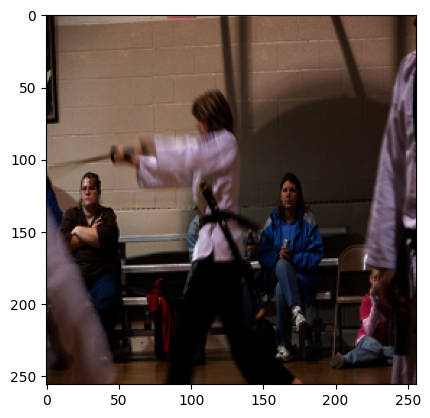

In [50]:
test_L, test_AB = dataset[0]
print(test_L.shape)
test_L = np.expand_dims(test_L, axis=0)
print(test_L.shape, test_AB.shape)
real_img = np.concatenate([test_L, test_AB])
print(real_img.shape)
real_img = real_img.transpose(1,2,0).astype(np.uint8)
real_img = labTorgb(real_img)
plt.imshow(real_img)

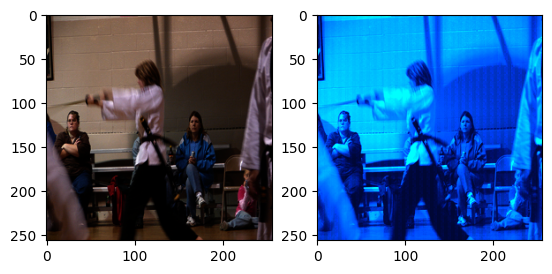

In [52]:
with torch.no_grad():
  model.load_state_dict(
      torch.load('AutoColor.pth', map_location=device)
  )
  input_tensor = torch.tensor(test_L)
  input_tensor = torch.unsqueeze(input_tensor, dim=0).to(device)
  pred_AB = model(input_tensor)

  pred_LAB = torch.cat([input_tensor, pred_AB], dim=1)
  pred_LAB = torch.squeeze(pred_LAB)
  pred_LAB = pred_LAB.permute(1,2,0).cpu().numpy()
  pred_LAB = labTorgb(pred_LAB.astype(np.uint8))

plt.subplot(1,2,1)
plt.imshow(real_img)
plt.subplot(1,2,2)
plt.imshow(pred_LAB)
plt.show()